### Import Modules

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, float64
import time
import os
import copy

### Open and Interpolate Real World Data

In [2]:
def load_excel_data(directory):
    """
    Load all Excel files and their sheets from the specified directory into a list of dataframes.

    Parameters:
    directory (str): The path to the folder containing the Excel files.

    Returns:
    list: A list of pandas dataframes containing the data from each sheet in the Excel files.
    """
    # Initialize an empty list to store dataframes
    datasets = []
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx"):
            file_path = os.path.join(directory, filename)

            # Load the Excel file
            excel_file = pd.ExcelFile(file_path)

            # Iterate over each sheet in the Excel file
            for sheet_name in excel_file.sheet_names:
                # Load the sheet into a dataframe and append to the datasets list
                df = pd.read_excel(excel_file, sheet_name=sheet_name)
                datasets.append(df)

    return datasets


def save_datasets_to_excel(datasets, output_file):
    """
    Save a list of dataframes to a single Excel file with each dataframe in a separate sheet.

    Parameters:
    datasets (list): A list of tuples containing filename, sheet name, and dataframe.
    output_file (str): The path to the output Excel file.
    """
    with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
        for i, (df) in enumerate(datasets):
            sheet_name_clean = f"Sheet_{i}"[
                :31
            ]  # Excel sheet names must be <= 31 chars
            df.to_excel(writer, sheet_name=sheet_name_clean, index=False)

In [3]:
# Example usage of the function
directory = "data/"
datasets = load_excel_data(directory)

In [4]:
# for i in range(len(datasets)):
#     plt.plot(datasets[i]['timestamp'], datasets[i]['trolley_position'], label='Trolley Position')
#     plt.plot(datasets[i]['timestamp'], datasets[i]['cable_length'], label='Cable Length')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.show()

In [5]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_motor_voltage"]
    )
    new_hoist_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["hoist_motor_voltage"]
    )

    interpolated_df = {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }

    interpolated_datasets.append(interpolated_df)

In [6]:
# for i in range(len(interpolated_datasets)):
#     plt.plot(interpolated_datasets[i]['time'], interpolated_datasets[i]['trolley_position'], label='Trolley Position')
#     plt.plot(interpolated_datasets[i]['time'], interpolated_datasets[i]['cable_length'], label='Cable Length')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.show()

In [7]:
# save_datasets_to_excel(interpolated_datasets, 'interpolated_datasets.xlsx')

### Open and Set Model Parameters

In [8]:
# Open the JSON file
with open("gantry_crane_parameters.json", "r") as file:
    data = json.load(file)

global all_parameters; all_parameters = data["gantry_crane_system_model"]["parameters"]
measured_parameters = {}
approximated_parameters = {}

for parameter in all_parameters:
    value = all_parameters[parameter]["value"]
    unit = all_parameters[parameter]["unit"]
    description = all_parameters[parameter]["description"]

    if all_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_parameters[parameter]

    # print(f"{parameter}: {value} {unit} ({description})")

### Declare Simulator Object

In [9]:
from model import Simulator
import utility as util

simulator = Simulator(DT, NUM_STEPS)


def cost_function(params, data_arrs):
    """
    Cost function is the average of the sum of the root mean squared errors between the interpolated data and the simulated data.
    """
    total_sum_RMSE = 0.0
    for i in range(len(data_arrs)):
        # Extract the parameters
        input_voltages = {
            "trolley_motor_voltage": data_arrs[i]["trolley_motor_voltage"],
            "hoist_motor_voltage": data_arrs[i]["hoist_motor_voltage"],
        }
        var_init_conditions = {
            "x": data_arrs[i]["trolley_position"][0],
            "l": data_arrs[i]["cable_length"][0],
            "theta": data_arrs[i]["sway_angle"][0],
        }
        # print(f"Simulating dataset {i} with parameters: {params}")
        # print(f"Inital conditions: {var_init_conditions}")
        simulator.simulate(params, input_voltages, var_init_conditions)
        simulation_results = simulator.get_results()
        sum_RMSE = util.calculate_sum_root_mean_squared_errors(
            pd.DataFrame(simulation_results), pd.DataFrame(data_arrs[i])
        )  # Skip the first row because it is time column
        print(f"Sum RMSE of dataset {i}: \t{round(sum_RMSE, 5)}", end="\r")

        if np.isnan(sum_RMSE):
            print(f"Sum RMSE of dataset {i} is NaN")
            return np.inf

        total_sum_RMSE += sum_RMSE
    return total_sum_RMSE / len(data_arrs)

### Define Searching Range to Optimize Model Parameters

In [10]:
optimize_range = {
    "trolley_mass": (1.0, 5.0),  # Done
    "trolley_damping_coefficient": (0.1, 10.0),  # Done
    "cable_damping_coefficient": (0.1, 10.0),  # Done
    "trolley_motor_rotator_inertia": (0.00001, 0.001),  # Done
    "trolley_motor_damping_coefficient": (0.1, 10.0),
    "trolley_motor_back_emf_constant": (0.001, 0.1),  # Done
    "trolley_motor_torque_constant": (0.01, 1.0),  # Done
    "hoist_motor_rotator_inertia": (0.000001, 0.0001),  # Done
    "hoist_motor_damping_coefficient": (0.1, 10.0),
    "hoist_motor_back_emf_constant": (0.01, 1.0),  # Done
    "hoist_motor_torque_constant": (0.0001, 0.01),  # Done
    "trolley_motor_activation_threshold_voltage": (0.1, 10.0),  # Done
    "hoist_motor_activation_threshold_voltage": (0.1, 10.0),  # Done
}

In [11]:
random_parameters = {}
for parameter in optimize_range:
    random_parameters[parameter] = np.random.uniform(
        optimize_range[parameter][0], optimize_range[parameter][1]
    )

print(random_parameters)

{'trolley_mass': 2.806989985098224, 'trolley_damping_coefficient': 5.929554756199011, 'cable_damping_coefficient': 5.266924695064255, 'trolley_motor_rotator_inertia': 0.00025939244327247943, 'trolley_motor_damping_coefficient': 1.4144604383673043, 'trolley_motor_back_emf_constant': 0.015356223657456276, 'trolley_motor_torque_constant': 0.2654493955442134, 'hoist_motor_rotator_inertia': 1.7513694966819247e-05, 'hoist_motor_damping_coefficient': 9.406617287610327, 'hoist_motor_back_emf_constant': 0.10434317298322067, 'hoist_motor_torque_constant': 0.003905921625119745}


In [12]:
# Open the JSON file
with open("best_SA_optimized_parameters.json", "r") as file:
    data = json.load(file)

for parameter in data:
    all_parameters[parameter]["value"] = data[parameter]["value"]
    print(f"{parameter}: {all_parameters[parameter]['value']}")

trolley_mass: 5.2020400203322685
container_mass: 1.128
trolley_damping_coefficient: 7.210939857316306
cable_damping_coefficient: 10.37551174283613
gravity_acceleration: 9.81
trolley_motor_inductance: 0.0001048
trolley_motor_resistance: 0.39
trolley_motor_rotator_inertia: 3.2609905613243114e-05
trolley_motor_damping_coefficient: 0.2961763471291016
trolley_motor_pulley_radius: 0.015
trolley_motor_torque_constant: 0.36374170475470263
trolley_motor_back_emf_constant: 0.0928380103517002
hoist_motor_inductance: 0.0073
hoist_motor_resistance: 9.5
hoist_motor_rotator_inertia: 8.42961563284119e-05
hoist_motor_damping_coefficient: 4.878663555367497
hoist_motor_pulley_radius: 0.015
hoist_motor_torque_constant: 0.003250129418430399
hoist_motor_back_emf_constant: 0.7872492957957005


## Simulated Annealing

In [13]:
INITIAL_TEMPERATURE = 5.0
COOLING_RATE = 0.995
MAX_ITERATION = 1000

In [14]:
current_temperature = INITIAL_TEMPERATURE

# Create a list of parameters to optimize
current_parameters = copy.deepcopy(all_parameters)
for parameter in approximated_parameters:
    current_parameters[parameter]["value"] = all_parameters[parameter]["value"]

for parameter in current_parameters:
    print(f"Setting {parameter} to {current_parameters[parameter]['value']}")

current_cost = cost_function(current_parameters, interpolated_datasets[:10])
print("Initial cost:", current_cost)

best_parameters = copy.deepcopy(current_parameters)
best_cost = current_cost

Setting trolley_mass to 5.2020400203322685
Setting container_mass to 1.128
Setting trolley_damping_coefficient to 7.210939857316306
Setting cable_damping_coefficient to 10.37551174283613
Setting gravity_acceleration to 9.81
Setting trolley_motor_inductance to 0.0001048
Setting trolley_motor_resistance to 0.39
Setting trolley_motor_rotator_inertia to 3.2609905613243114e-05
Setting trolley_motor_damping_coefficient to 0.2961763471291016
Setting trolley_motor_pulley_radius to 0.015
Setting trolley_motor_torque_constant to 0.36374170475470263
Setting trolley_motor_back_emf_constant to 0.0928380103517002
Setting hoist_motor_inductance to 0.0073
Setting hoist_motor_resistance to 9.5
Setting hoist_motor_rotator_inertia to 8.42961563284119e-05
Setting hoist_motor_damping_coefficient to 4.878663555367497
Setting hoist_motor_pulley_radius to 0.015
Setting hoist_motor_torque_constant to 0.003250129418430399
Setting hoist_motor_back_emf_constant to 0.7872492957957005
Initial cost: 0.35302932118666

In [15]:
for iteration in range(MAX_ITERATION):
    # Generate a new set of parameters
    new_parameters = copy.deepcopy(current_parameters)
    for parameter in approximated_parameters:
        new_parameters[parameter]["value"] += np.random.uniform(-optimize_range[parameter][0], optimize_range[parameter][0])
        if new_parameters[parameter]["value"] <= 0:
            new_parameters[parameter]["value"] = optimize_range[parameter][0]

    # Calculate the cost of the new parameters
    new_cost = cost_function(new_parameters, interpolated_datasets[:10])

    # Calculate the acceptance probability
    acceptance_probability  = 0.0
    if new_cost < current_cost:
        acceptance_probability = 1.0
    else:
        acceptance_probability = np.exp(-(new_cost - current_cost) / current_temperature)

    # Accept or reject the new parameters
    if acceptance_probability >= np.random.rand():
        current_parameters = copy.deepcopy(new_parameters)
        current_cost = new_cost

    # Update the best parameters and cost
    if current_cost < best_cost:
        best_parameters = copy.deepcopy(current_parameters)
        best_cost = current_cost

    # Cooling the temperature
    current_temperature *= COOLING_RATE
    
    print(f"Iteration: {iteration}, Cost: {current_cost}, Best Cost: {best_cost}")
    print(f"Best Parameters:", end=" ")
    for parameter in approximated_parameters:
        print(f"{parameter}: {best_parameters[parameter]['value']}", end=" | ")
    print()
    print("_" * 100)

Iteration: 0, Cost: 0.3737095019717547, Best Cost: 0.3530293211866695
Best Parameters: trolley_mass: 5.2020400203322685 | trolley_damping_coefficient: 7.210939857316306 | cable_damping_coefficient: 10.37551174283613 | trolley_motor_rotator_inertia: 3.2609905613243114e-05 | trolley_motor_damping_coefficient: 0.2961763471291016 | trolley_motor_torque_constant: 0.36374170475470263 | trolley_motor_back_emf_constant: 0.0928380103517002 | hoist_motor_rotator_inertia: 8.42961563284119e-05 | hoist_motor_damping_coefficient: 4.878663555367497 | hoist_motor_torque_constant: 0.003250129418430399 | hoist_motor_back_emf_constant: 0.7872492957957005 | 
____________________________________________________________________________________________________
Iteration: 1, Cost: 0.3915352914072545, Best Cost: 0.3530293211866695
Best Parameters: trolley_mass: 5.2020400203322685 | trolley_damping_coefficient: 7.210939857316306 | cable_damping_coefficient: 10.37551174283613 | trolley_motor_rotator_inertia: 3.2

/home/icodes/Documents/TA_13319004/gantry_crane_model_optimizer/utility.py:23: RuntimeWarning: overflow encountered in scalar add
  sum_squared_error += (y1[j] - y2[j]) ** 2
/home/icodes/Documents/TA_13319004/gantry_crane_model_optimizer/utility.py:23: RuntimeWarning: overflow encountered in scalar power
  sum_squared_error += (y1[j] - y2[j]) ** 2


Sum RMSE of dataset 2 is NaN
Iteration: 37, Cost: 0.5723200291498742, Best Cost: 0.35180685431107916
Best Parameters: trolley_mass: 1.9359736115372896 | trolley_damping_coefficient: 7.529560965756676 | cable_damping_coefficient: 10.399080645891283 | trolley_motor_rotator_inertia: 1.120490997498645e-05 | trolley_motor_damping_coefficient: 0.2877119071556121 | trolley_motor_torque_constant: 0.3750128779139848 | trolley_motor_back_emf_constant: 0.09439426270600888 | hoist_motor_rotator_inertia: 7.949902906284213e-05 | hoist_motor_damping_coefficient: 5.079910913739685 | hoist_motor_torque_constant: 0.0031079030859985294 | hoist_motor_back_emf_constant: 0.8073373138206642 | 
____________________________________________________________________________________________________
Sum RMSE of dataset 2 is NaN987
Iteration: 38, Cost: 0.5723200291498742, Best Cost: 0.35180685431107916
Best Parameters: trolley_mass: 1.9359736115372896 | trolley_damping_coefficient: 7.529560965756676 | cable_damping_

In [16]:
# Save the best parameters to a JSON file
with open("best_SA_optimized_parameters.json", "w") as file:
    json.dump(best_parameters, file, indent=4)

## Gradient Descent

### Define learning rate for each parameter

In [17]:
parameters_learning_rate = {}

for parameter in optimize_range:
    parameters_learning_rate[parameter] = min(optimize_range[parameter]) / 2

print("Learning rate:", parameters_learning_rate)

# Create random value for each parameter within the specified range
random_parameters = {}
for parameter in optimize_range:
    random_parameters[parameter] = np.random.uniform(
        optimize_range[parameter][0], optimize_range[parameter][1]
    )

print("Initial value:", random_parameters)

Learning rate: {'trolley_mass': 0.1, 'trolley_damping_coefficient': 0.01, 'cable_damping_coefficient': 0.01, 'trolley_motor_rotator_inertia': 1.0000000000000002e-06, 'trolley_motor_damping_coefficient': 0.01, 'trolley_motor_back_emf_constant': 0.0001, 'trolley_motor_torque_constant': 0.001, 'hoist_motor_rotator_inertia': 1e-07, 'hoist_motor_damping_coefficient': 0.01, 'hoist_motor_back_emf_constant': 0.001, 'hoist_motor_torque_constant': 1e-05}
Initial value: {'trolley_mass': 2.8115088350200206, 'trolley_damping_coefficient': 3.697788386792115, 'cable_damping_coefficient': 8.389813760234846, 'trolley_motor_rotator_inertia': 0.00018699467934648963, 'trolley_motor_damping_coefficient': 6.95124407588135, 'trolley_motor_back_emf_constant': 0.013522061132118339, 'trolley_motor_torque_constant': 0.14990166773936975, 'hoist_motor_rotator_inertia': 5.111428223798954e-06, 'hoist_motor_damping_coefficient': 5.424308893450729, 'hoist_motor_back_emf_constant': 0.7998675033593727, 'hoist_motor_torq

In [18]:
optimized_parameters = all_parameters

for parameter in random_parameters:
    optimized_parameters[parameter]["value"] = random_parameters[parameter]

old_parameter = optimized_parameters

In [20]:
# interpolated_array = [
#     value
#     for value in range(len(interpolated_datasets[i].values))
#     for i in range(len(interpolated_datasets))
# ]
# dataframe_header = [column for column in interpolated_datasets[0].columns]

# print("Interpolated array shape:", interpolated_array)
# print("Dataframe header:", dataframe_header)

#### Optimize Model Parameters with Gradient Descent Algoritm

In [ ]:
# num_steps = len(interpolated_array[0])
# input_voltages = {
#     "trolley_motor_voltage": interpolated_array[4],
#     "hoist_motor_voltage": interpolated_array[5],
# }
# variables_initial_conditions = {
#     "x": interpolated_array[1][0],
#     "l": interpolated_array[2][0],
#     "theta": interpolated_array[3][0],
# }
# epoch = 0
# count = 0
# epochs = []
# total_sum_root_mean_squared_errors_array = []
# while epoch <= 2000:
#     steps = 0
#     total_sum_root_mean_squared_errors = 0
#     for parameter in optimize_range:
#         simulator.simulate(
#             optimized_parameters, input_voltages, variables_initial_conditions
#         )
#         simulated_array = simulator.get_results()

#         sum_root_mean_squared_errors = calculate_sum_root_mean_squared_errors(
#             dataframe_header, interpolated_array, simulated_array
#         )

#         # Calculate the cost function derivative relative to parameter value
#         h = 1e-6
#         optimized_parameters[parameter]["value"] += h
#         simulator.simulate(
#             optimized_parameters, input_voltages, variables_initial_conditions
#         )
#         simulated_array_h = simulator.get_results()

#         sum_root_mean_squared_errors_h = calculate_sum_root_mean_squared_errors(
#             dataframe_header, interpolated_array, simulated_array_h
#         )

#         derivative = (sum_root_mean_squared_errors_h - sum_root_mean_squared_errors) / h

#         # print(derivative)

#         steps = parameters_learning_rate[parameter] * derivative
#         optimized_parameters[parameter]["steps"] = steps
#         optimized_parameters[parameter]["value"] -= steps

#         # print(end="\r")
#         # print(
#         #     "Parameter:",
#         #     parameter,
#         #     "| Value:",
#         #     optimized_parameters[parameter]["value"],
#         #     "| Loss:",
#         #     sum_root_mean_squared_errors,
#         #     "Step size:",
#         #     steps,
#         #     end="\r",
#         # )

#         total_sum_root_mean_squared_errors += sum_root_mean_squared_errors

#     count = 0
#     for parameter in optimize_range:
#         if abs(optimized_parameters[parameter]["steps"]) < 1e-6:
#             count += 1

#     print(
#         "Epoch:",
#         epoch,
#         "\t| Total loss:",
#         round(total_sum_root_mean_squared_errors, 6),
#         "\t| Converge count:",
#         count,
#         end="\r",
#     )

#     if count == len(optimized_parameters):
#         break

#     epochs.append(epoch)
#     total_sum_root_mean_squared_errors_array.append(total_sum_root_mean_squared_errors)

#     epoch += 1

In [ ]:
# plt.plot(epochs, total_sum_root_mean_squared_errors_array)
# plt.show()

In [ ]:
# json_string = json.dumps(optimized_parameters, indent=4)

# # Step 3: Write the JSON string to a file
# with open("optimized_parameter.json", "w") as json_file:
#     json_file.write(json_string)

# for parameter in optimized_parameters:
#     # print(parameter)
#     if old_parameter[parameter]["value"] != optimized_parameters[parameter]["value"]:
#         print("Old", parameter, "value:", old_parameter[parameter]["value"])
#         print("Old", parameter, "value:", optimized_parameters[parameter]["value"])

In [21]:
# Open the JSON file
with open("best_SA_optimized_parameters.json", "r") as file:
    data = json.load(file)

test_parameters = copy.deepcopy(all_parameters)
for parameter in data:
    test_parameters[parameter]["value"] = data[parameter]["value"]
    print(f"{parameter}: {test_parameters[parameter]['value']}")

trolley_mass: 8.991576545071803
container_mass: 1.128
trolley_damping_coefficient: 6.889572346236602
cable_damping_coefficient: 10.903903019629983
gravity_acceleration: 9.81
trolley_motor_inductance: 0.0001048
trolley_motor_resistance: 0.39
trolley_motor_rotator_inertia: 8.998391818253167e-06
trolley_motor_damping_coefficient: 0.4679303516081099
trolley_motor_pulley_radius: 0.015
trolley_motor_torque_constant: 0.608049367827118
trolley_motor_back_emf_constant: 0.10030640169750167
hoist_motor_inductance: 0.0073
hoist_motor_resistance: 9.5
hoist_motor_rotator_inertia: 7.612922523628766e-05
hoist_motor_damping_coefficient: 0.26817873607016035
hoist_motor_pulley_radius: 0.015
hoist_motor_torque_constant: 0.0024381124506624306
hoist_motor_back_emf_constant: 0.7145678031108188


### Simulate Optimized Parameters and Compare to Real Data

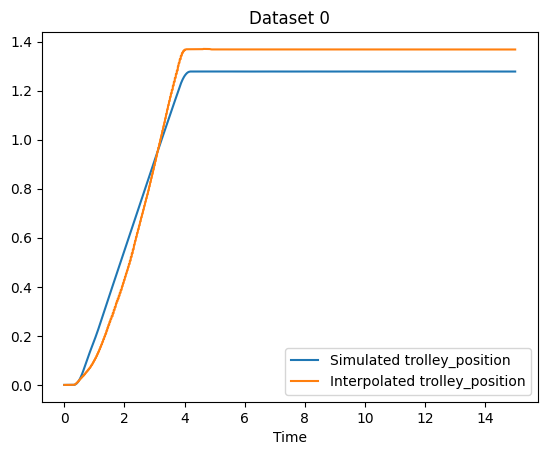

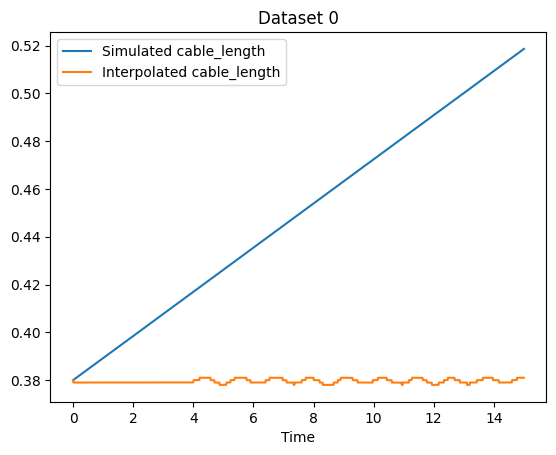

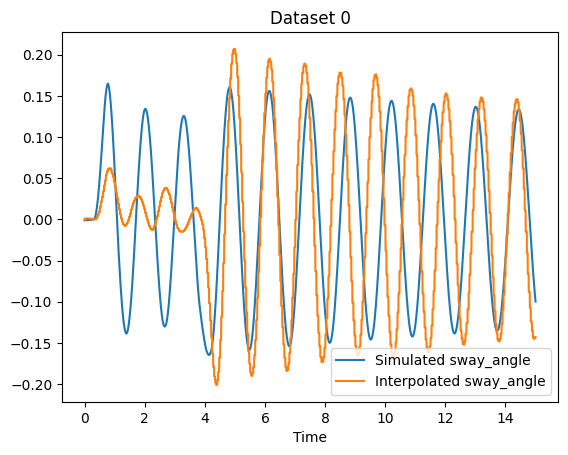

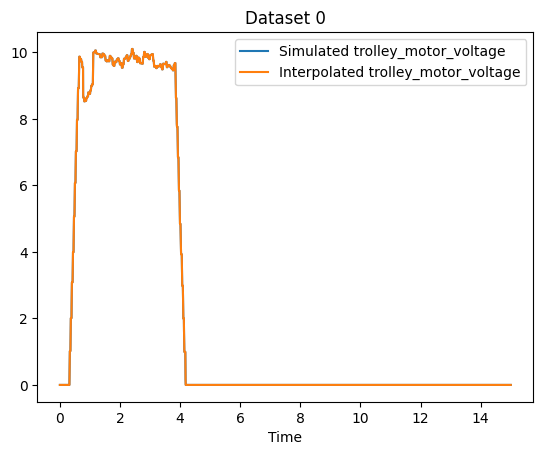

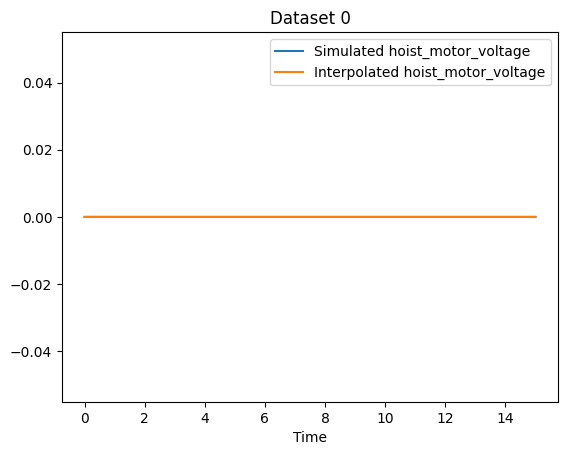

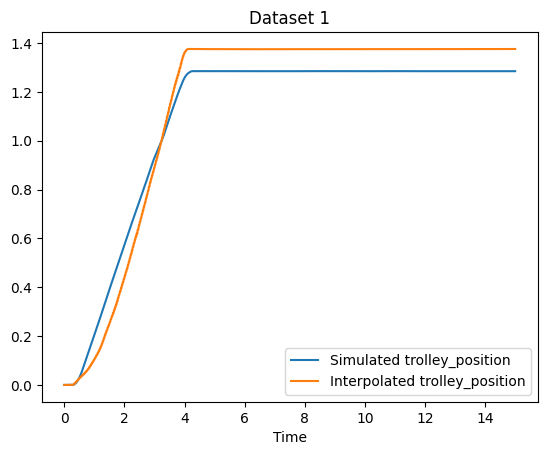

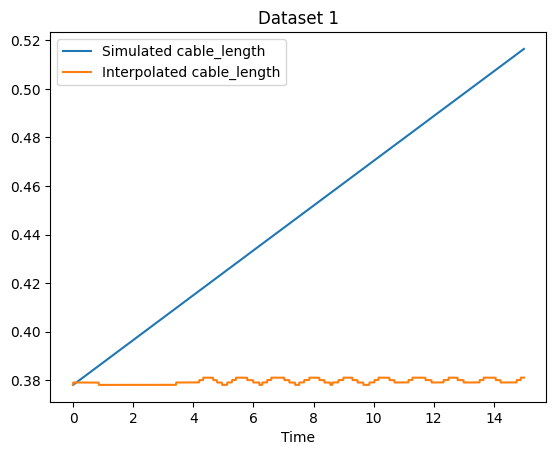

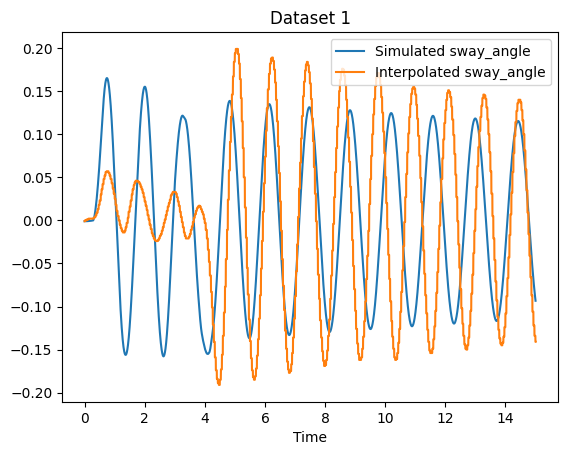

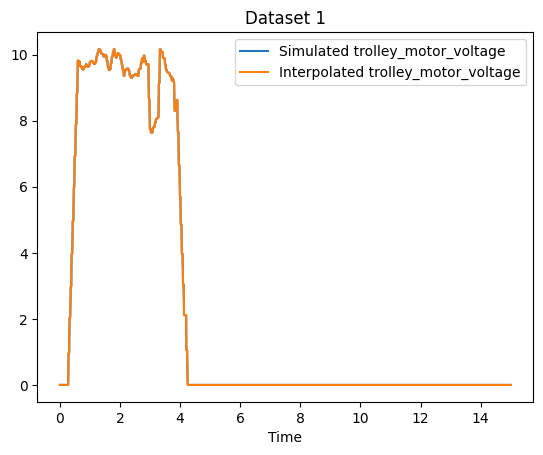

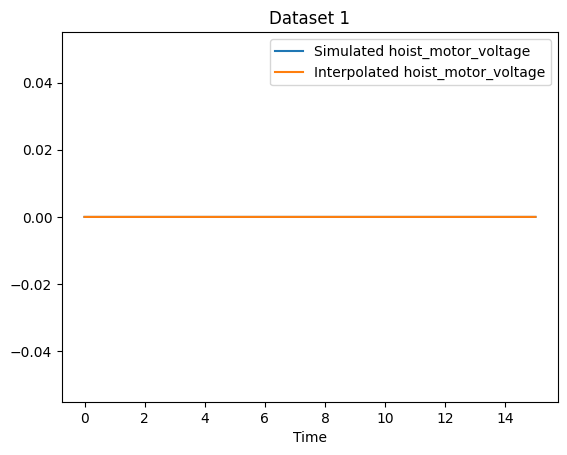

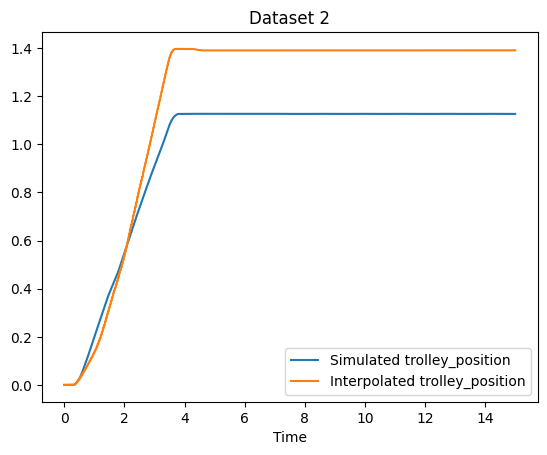

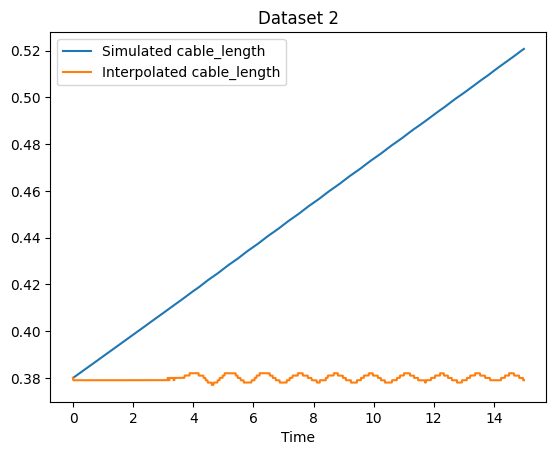

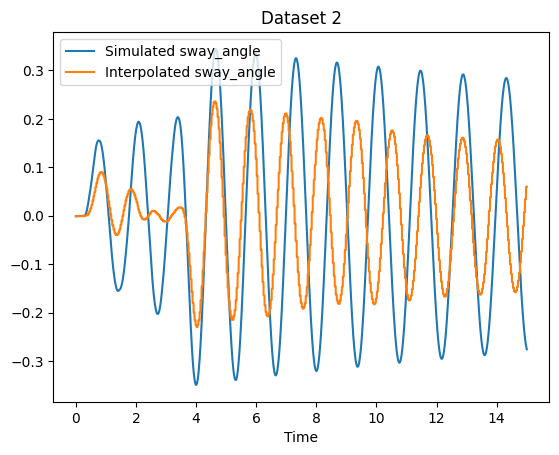

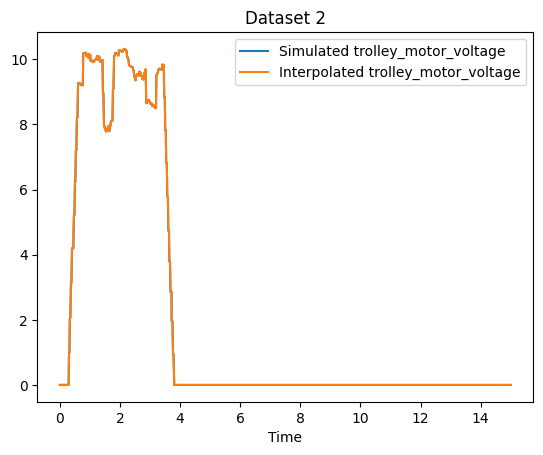

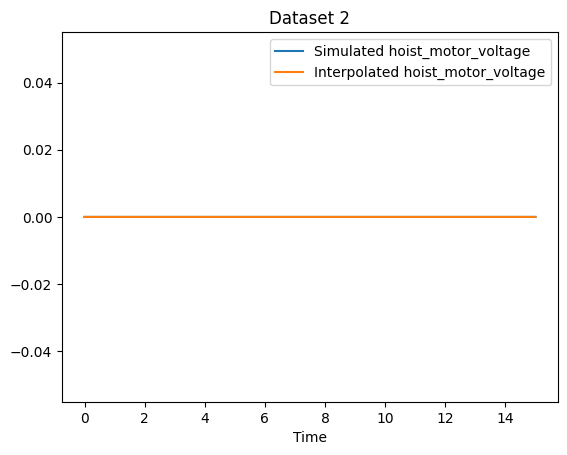

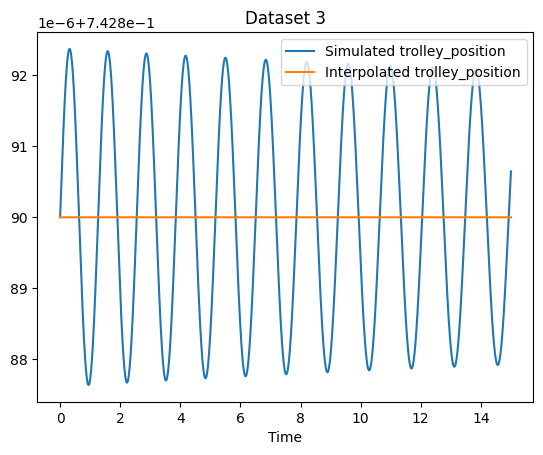

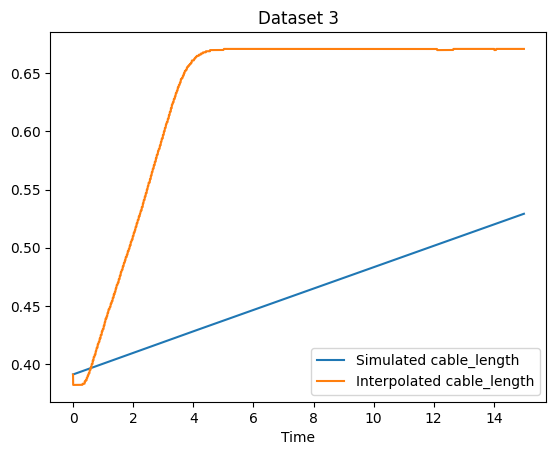

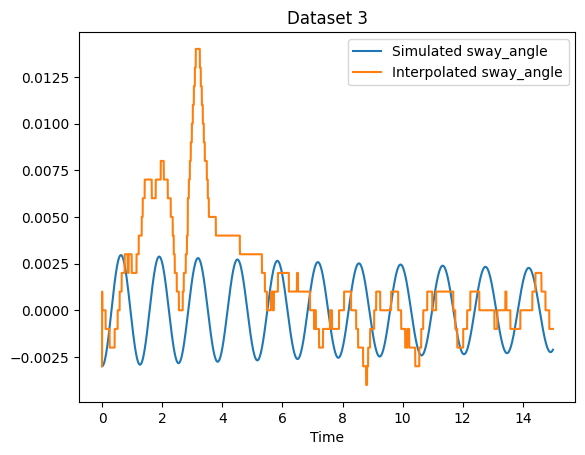

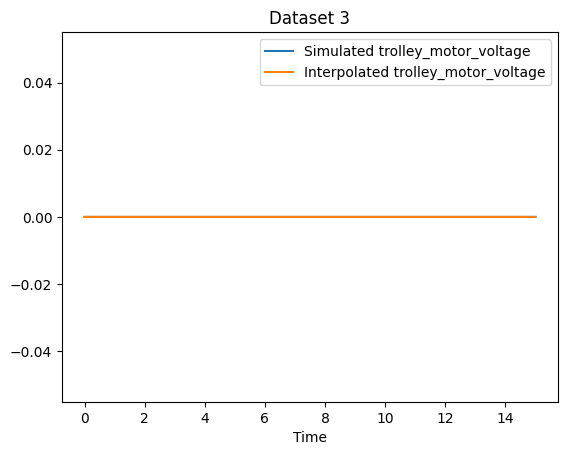

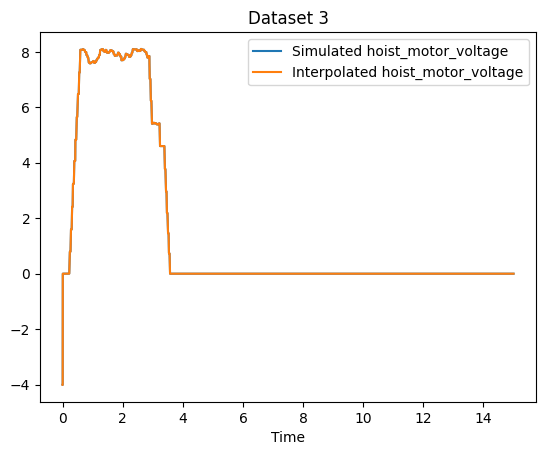

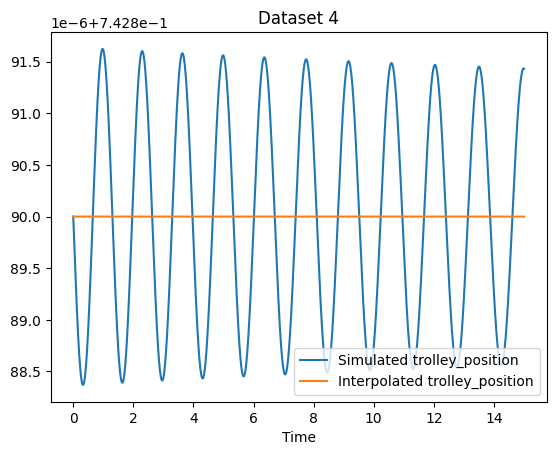

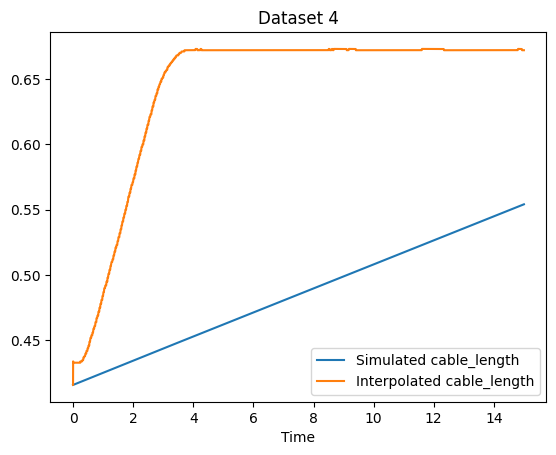

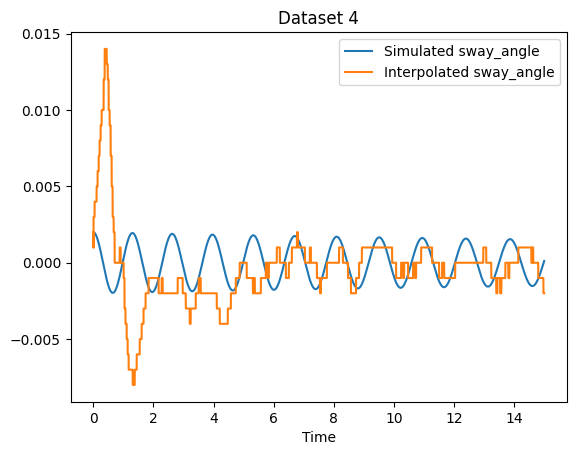

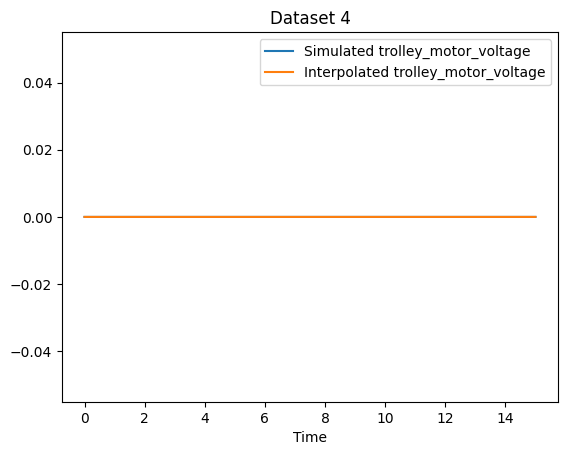

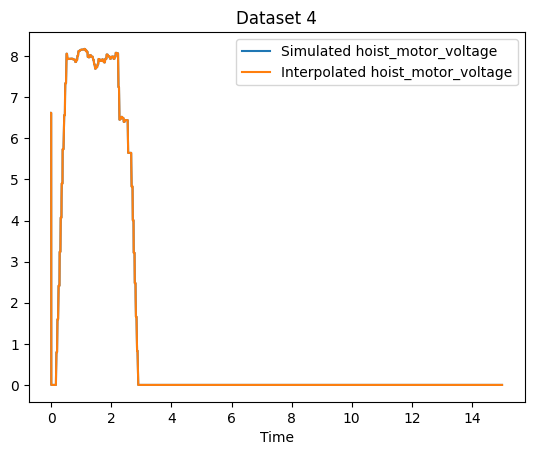

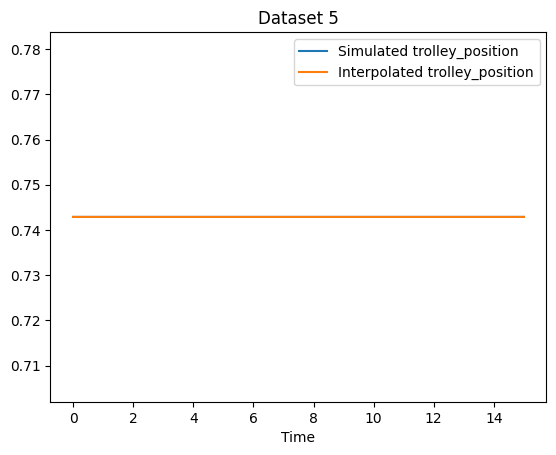

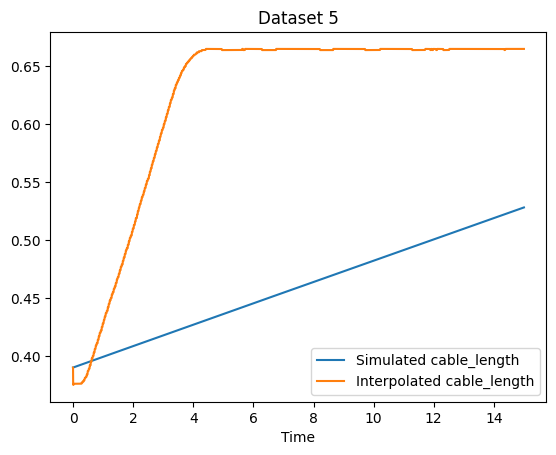

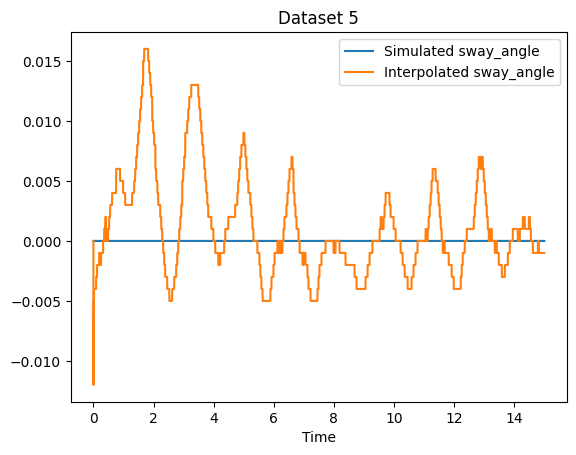

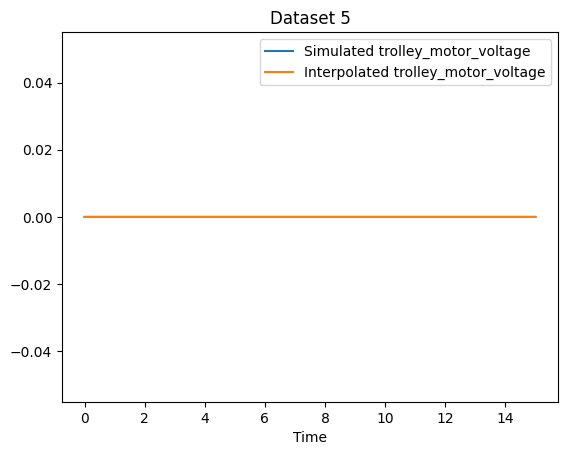

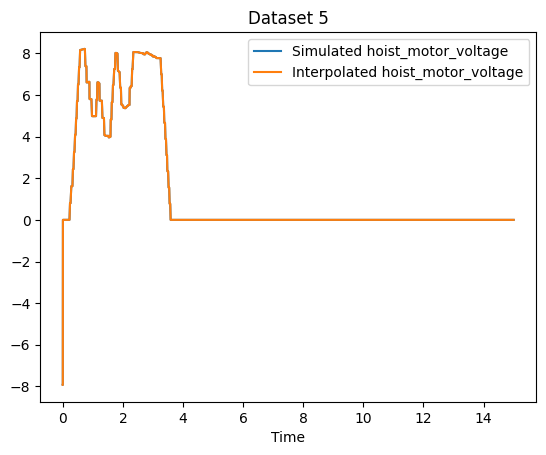

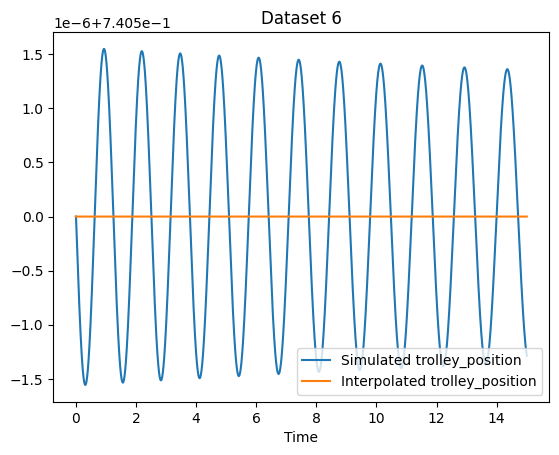

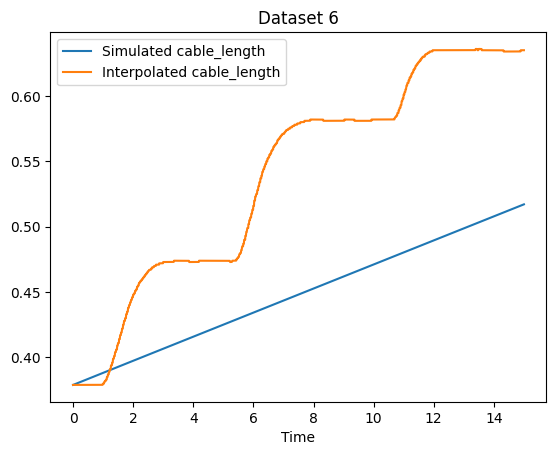

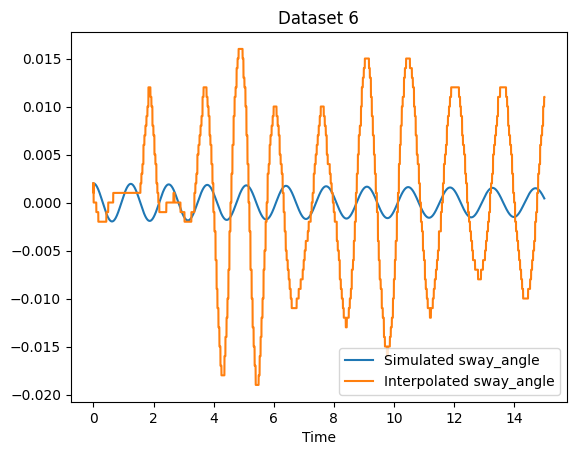

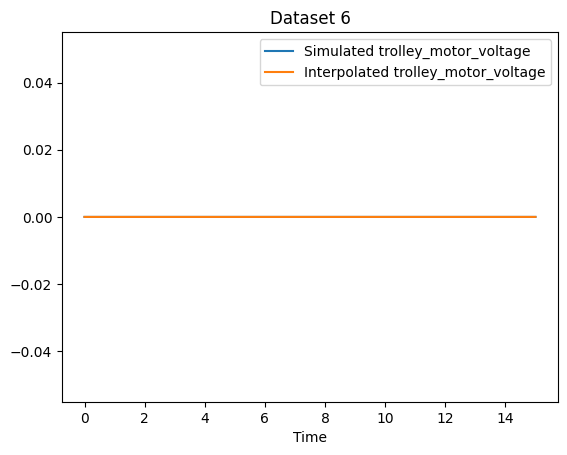

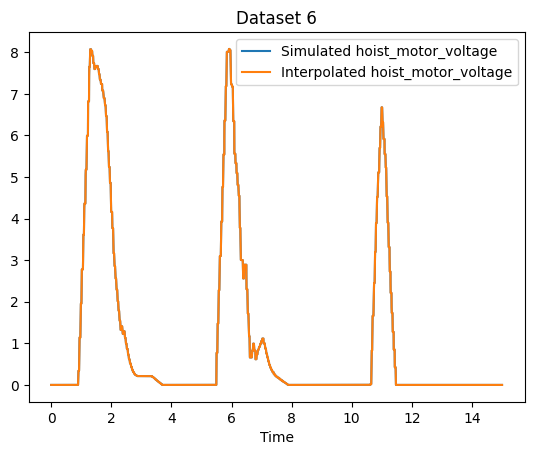

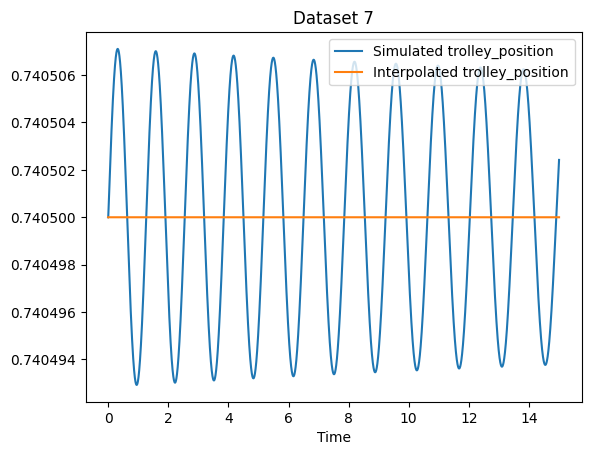

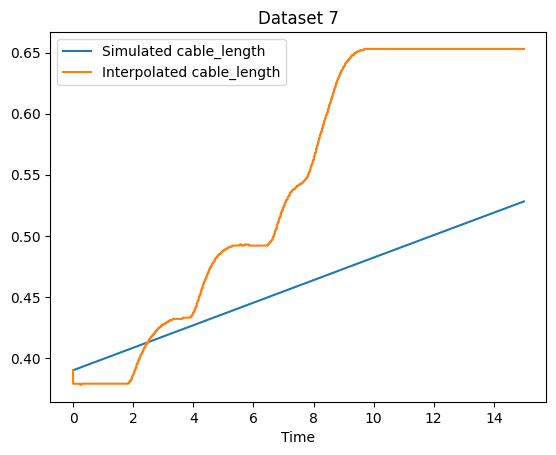

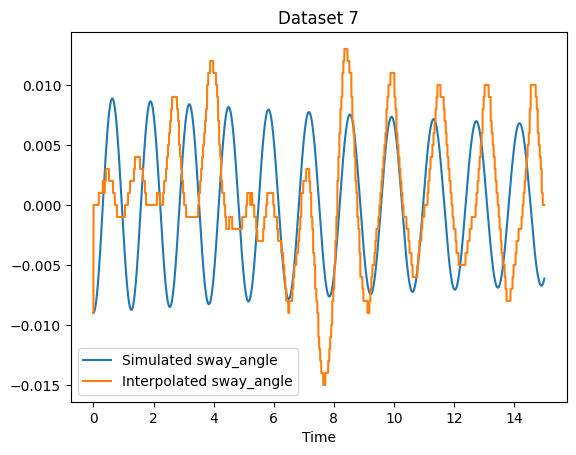

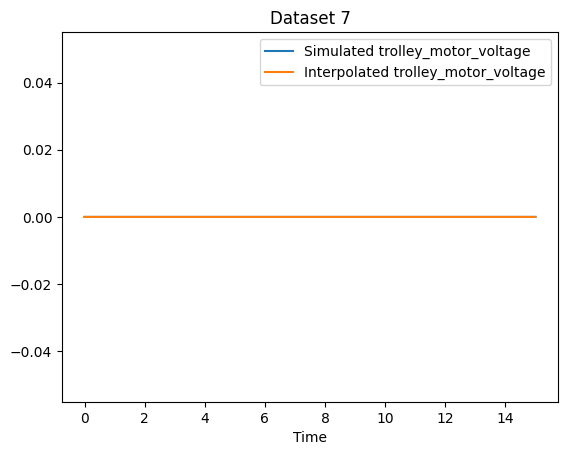

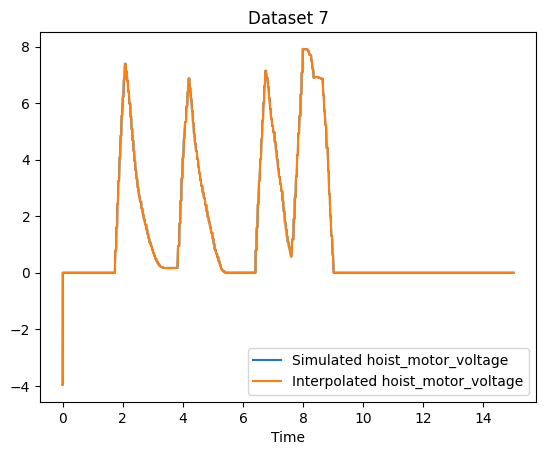

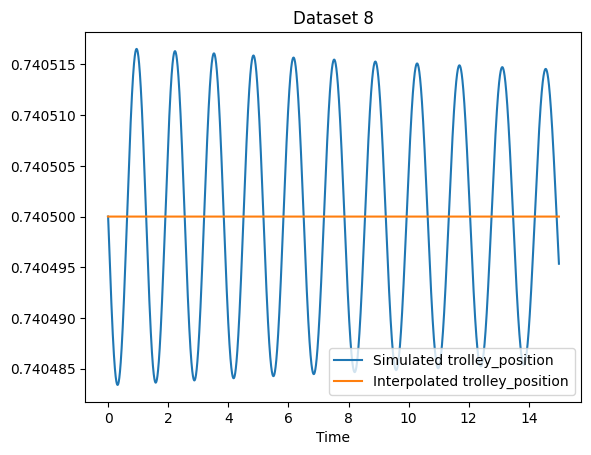

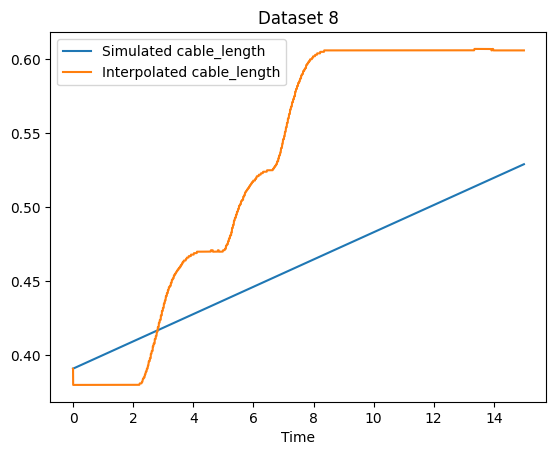

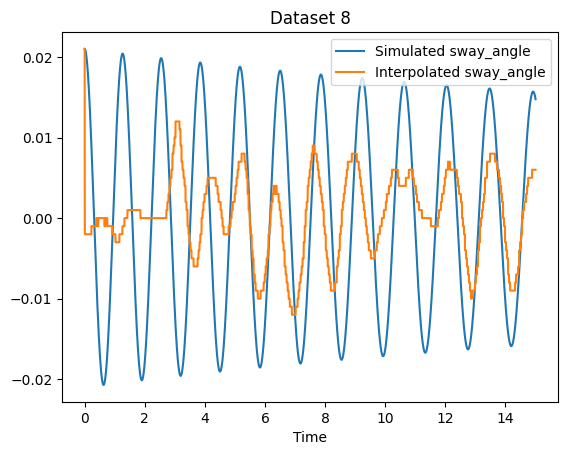

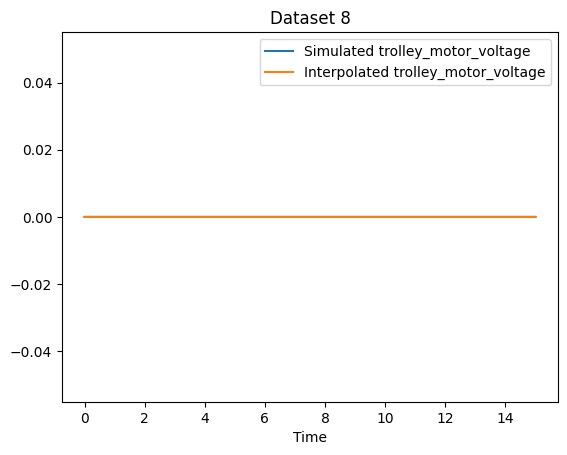

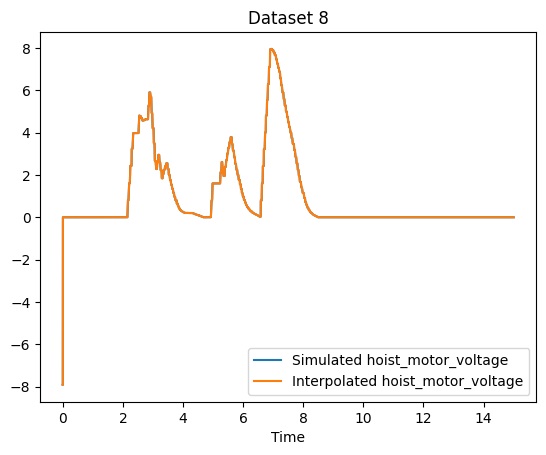

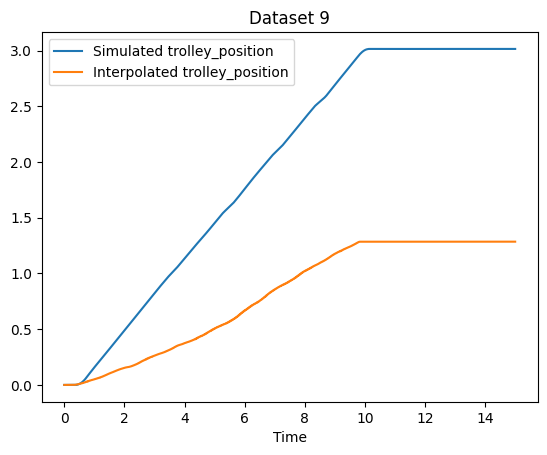

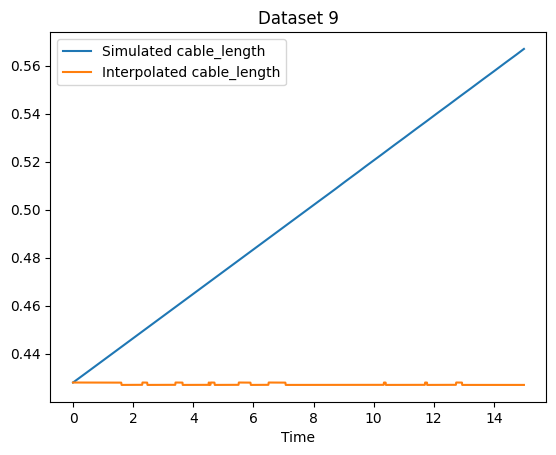

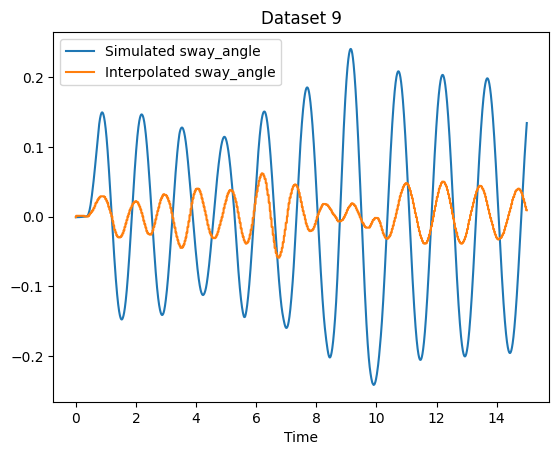

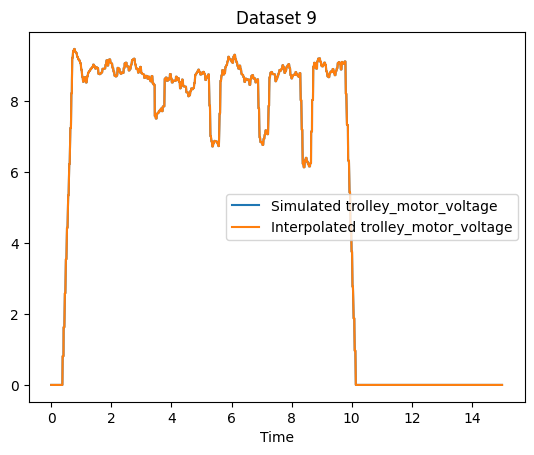

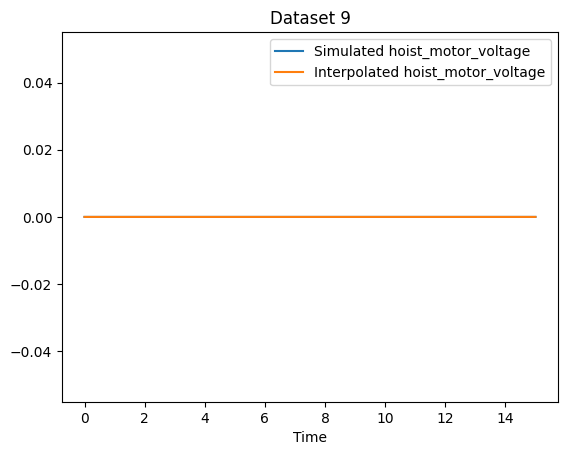

In [28]:
# num_steps = len(interpolated_array[0])
i = 0
for dataset in interpolated_datasets[:10]:
    # Extract the parameters
    input_voltages = {
        "trolley_motor_voltage": dataset["trolley_motor_voltage"],
        "hoist_motor_voltage": dataset["hoist_motor_voltage"],
    }
    var_init_conditions = {
        "x": dataset["trolley_position"][0],
        "l": dataset["cable_length"][0],
        "theta": dataset["sway_angle"][0],
    }
    # print(f"Simulating dataset {i} with parameters: {params}")
    # print(f"Inital conditions: {var_init_conditions}")
    simulator.simulate(test_parameters, input_voltages, var_init_conditions)
    simulation_results = simulator.get_results()

    for column in simulation_results:
        if column == "time":
            continue
        plt.plot(simulation_results["time"], simulation_results[column], label=f"Simulated {column}")
        plt.plot(dataset["time"], dataset[column], label=f"Interpolated {column}")
        plt.xlabel("Time")
        plt.title(f"Dataset {i}")
        plt.legend()
        plt.show()

    i += 1